In [1]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2023-06-06 14:48:04--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-06-06 14:48:04 (35.1 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/6895377/releases/pybind11-install.s

In [2]:
!pip install mshr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from dolfin import *
import mshr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as tri

In [4]:
# Follow https://fenics-handson.readthedocs.io/en/latest/navierstokes/doc.html#stokes-flow-around-cylinder
def build_space(N_circle, N_bulk, u_in):
    """Prepare data for DGF benchmark. Return function
    space, list of boundary conditions and surface measure
    on the cylinder."""

    # Define domain
    center = Point(0.2, 0.2)
    radius = 0.05
    L = 2.2
    W = 0.41
    geometry = mshr.Rectangle(Point(0.0, 0.0), Point(L, W)) \
             - mshr.Circle(center, radius, N_circle)

    # Build mesh
    mesh = mshr.generate_mesh(geometry, N_bulk)

    # Construct facet markers
    bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
    for f in facets(mesh):
        mp = f.midpoint()
        if near(mp[0], 0.0):  # inflow
            bndry[f] = 1
        elif near(mp[0], L):  # outflow
            bndry[f] = 2
        elif near(mp[1], 0.0) or near(mp[1], W):  # walls
            bndry[f] = 3
        elif mp.distance(center) <= radius:  # cylinder
            bndry[f] = 5

    # Build function spaces (Taylor-Hood)
    P2 = VectorElement("P", mesh.ufl_cell(), 2)
    P1 = FiniteElement("P", mesh.ufl_cell(), 1)
    TH = MixedElement([P2, P1])
    W = FunctionSpace(mesh, TH)

    # Prepare Dirichlet boundary conditions
    bc_walls = DirichletBC(W.sub(0), (0, 0), bndry, 3)
    bc_cylinder = DirichletBC(W.sub(0), (0, 0), bndry, 5)
    bc_in = DirichletBC(W.sub(0), u_in, bndry, 1)
    bcs = [bc_cylinder, bc_walls, bc_in]

    # Prepare surface measure on cylinder
    ds_circle = Measure("ds", subdomain_data=bndry, subdomain_id=5)

    return mesh, W, bcs, ds_circle


def solve_navier_stokes(W, nu, bcs):
    """Solve steady Navier-Stokes and return the solution"""

    # Define variational forms
    v, q = TestFunctions(W)
    w = Function(W)
    u, p = split(w)
    F = nu*inner(grad(u), grad(v))*dx + dot(dot(grad(u), u), v)*dx \
        - p*div(v)*dx - q*div(u)*dx

    # Solve the problem
    solve(F == 0, w, bcs)

    return w

In [5]:
u_in = Expression(("4.0*U*x[1]*(0.41 - x[1])/(0.41*0.41)", "0.0"),
                    degree=2, U=0.3)
nu = Constant(0.001)

# Discretization parameters
N_circle = 128
N_bulk = 256

# Prepare function space, BCs and measure on circle
mesh, W, bcs, ds_circle = build_space(N_circle, N_bulk, u_in)

# Solve Stokes
w = solve_navier_stokes(W, nu, bcs)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_8dcc7ff1a2a5155b4ca8e0d58559cea9e604269b

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0185697 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 1.26018 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_6ab56968c6ffa883272fd990bd40fad8bf858cca

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00857592 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.100496 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_f4c31f6e8b0e7ddceb14ce599aa08d063c1bdf82

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0259781 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.057137 seconds.

INFO:FFC:Compiler stage 3:

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00581551 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0191085 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4d847efd0e024182887afe3327d7ce0dc8b4dc04

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_1, f_29]'
  Unique elements:           'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, R0(?,?), Vector
                             <2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, R0(?,?), Vector
                             <2 x CG1(?,?)>, Vector<2 x CG2(?,?)>, CG1(?,?), CG2(?,?
                             )'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule: 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0030458 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0171084 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_17d5bd7e022a45e71c9f390bd00f3f09885a1fd0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00545692 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0131114 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0073185 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.014904 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO:F

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c97a8c8738c94f629de9510511d642c71287e244

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_1, f_29]'
  Unique elements:           'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, R0(?,?), Vector
                             <2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, R0(?,?), Vector
                             <2 x CG1(?,?)>, Vector<2 x CG2(?,?)>, CG1(?,?), CG2(?,?
                             )'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_r

In [6]:
center = Point(0.2, 0.2)
radius = 0.05
L = 2.2
W = 0.41

bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
for f in facets(mesh):
    mp = f.midpoint()
    if near(mp[0], 0.0):  # inflow
        bndry[f] = 1
    elif near(mp[0], L):  # outflow
        bndry[f] = 2
    elif near(mp[1], 0.0) or near(mp[1], W):  # walls
        bndry[f] = 3
    elif mp.distance(center) <= radius:  # cylinder
        bndry[f] = 5


inflow_coords = []
outflow_coords = []
wall_coords = []
cylinder_coords = []

for f in facets(mesh):
    if bndry[f] == 1:  # inflow
        for vertex in vertices(f):
            inflow_coords.append(vertex.point().array())
    elif bndry[f] == 2:  # outflow
        for vertex in vertices(f):
            outflow_coords.append(vertex.point().array())
    elif bndry[f] == 3:  # walls
        for vertex in vertices(f):
            wall_coords.append(vertex.point().array())
    elif bndry[f] == 5:  # cylinder
        for vertex in vertices(f):
            cylinder_coords.append(vertex.point().array())

inflow_coords = np.array(inflow_coords)[:,:2]
outflow_coords = np.array(outflow_coords)[:,:2]
wall_coords = np.array(wall_coords)[:,:2]
cylinder_coords = np.array(cylinder_coords)[:,:2]

coords = mesh.coordinates()
x = coords[:, 0]
y = coords[:, 1]

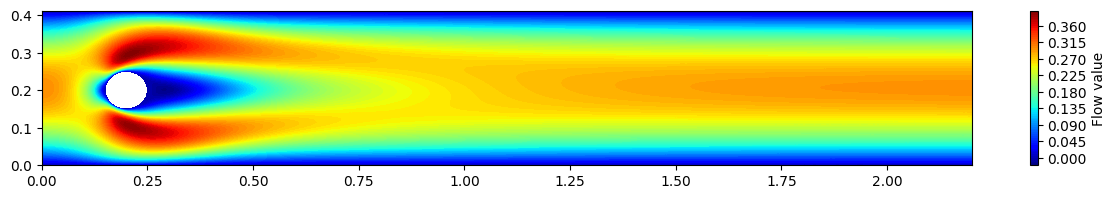

In [7]:
coordinates = mesh.coordinates()
x = coordinates[:, 0]
y = coordinates[:, 1]

U, p = w.split()
u, v = U.split()

u_values = np.array([u(x, y) for x, y in coordinates])
v_values = np.array([v(x, y) for x, y in coordinates])
p_values = np.array([p(x, y) for x, y in coordinates])

triang = tri.Triangulation(x, y)

x_tri = x[triang.triangles].mean(axis=1)
y_tri = y[triang.triangles].mean(axis=1)
dist_from_center = np.sqrt((x_tri - center[0])**2 + (y_tri - center[1])**2)
triang.set_mask(dist_from_center < radius)


fig = plt.figure(figsize=(15,2))
plt.tricontourf(triang, u_values, cmap='jet', levels=100)
plt.colorbar(label='Flow value')

In [8]:
data_dict = {'u':u_values, 
             'v':v_values, 
             'p':p_values, 
             'coords':coords, 
             'inflow_coords': inflow_coords,
             'outflow_coords': outflow_coords,
             'wall_coords': wall_coords,
             'cylinder_coords': cylinder_coords,
             'nu':0.001}
np.save('ns_steady.npy', data_dict)